In [388]:
from statsmodels.stats.power import TTestIndPower
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import brentq
from scipy.stats import norm, t
import scipy
import streamlit
import matplotlib

In [219]:
# Example: 2-sample t-test
analysis = TTestIndPower()
effect_size = .1   # medium effect
alpha = 0.05
power = 0.5

# Compute required sample size
sample_size = analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha, alternative="two-sided")
print(sample_size)

769.1660648307045


## Two Sample T

### Power Calc

In [ ]:
def power_two_sample_ttest_unequal_variance(n1, n2, mu1, mu2, s1, s2, alpha=0.05, alternative='two-sided'):
    """
    Calculate power for a two-sample t-test.
    """
    numerator = (s1**2 / n1 + s2**2 / n2)**2
    denominator = ((s1**2 / n1)**2) / (n1 - 1) + ((s2**2 / n2)**2) / (n2 - 1)
    df = np.floor(numerator / denominator)

    pooled_sd = np.sqrt((s1**2 + s2**2) / 2)
    effect_size = (mu1 - mu2) / pooled_sd
    
    se = np.sqrt(s1**2 / n1 + s2**2 / n2)
    ncp = (mu1 - mu2) / se

    t_crit = stats.t.ppf(1 - alpha / 2, df) if alternative == 'two-sided' else stats.t.ppf(1 - alpha, df)

    if alternative == 'two-sided':
        power = 1 - stats.nct.cdf(t_crit, df, ncp) + stats.nct.cdf(-t_crit, df, ncp)
    elif alternative == 'larger':
        power = 1 - stats.nct.cdf(t_crit, df, ncp)
    elif alternative == 'smaller':
        power = stats.nct.cdf(-t_crit, df, ncp)
    else:
        raise ValueError("alternative must be 'two-sided', 'larger', or 'smaller'")

    if np.isnan(power):
        power = 0.0
    
    return power, effect_size, df


power, effect_size, df = power_two_sample_ttest_unequal_variance(n1=50, n2=50, mu1=5, mu2=0, s1=1, s2=1, alternative="smaller")
power

-1.6607146101002037 97.0 25.0


0.0

In [324]:
def power_two_sample_ttest_equal_variance(effect_size, n1, n2, alpha=0.05, alternative='two-sided'):
    """
    Calculate power for a two-sample t-test.
    """
    df = n1 + n2 - 2
    ncp = effect_size * np.sqrt((n1 * n2) / (n1 + n2))

    t_crit = stats.t.ppf(1 - alpha / 2, df) if alternative == 'two-sided' else stats.t.ppf(1 - alpha, df)

    if alternative == 'two-sided':
        power = 1 - stats.nct.cdf(t_crit, df, ncp) + stats.nct.cdf(-t_crit, df, ncp)
    elif alternative == 'larger':
        power = 1 - stats.nct.cdf(t_crit, df, ncp)
    elif alternative == 'smaller':
        power = stats.nct.cdf(-t_crit, df, ncp)
    else:
        raise ValueError("alternative must be 'two-sided', 'larger', or 'smaller'")
    
    return power, df


power_two_sample_ttest_equal_variance(effect_size=.525, n1=50, n2=50, alternative="two-sided")

(np.float64(0.7386673636579617), 98)

### Plot Curves

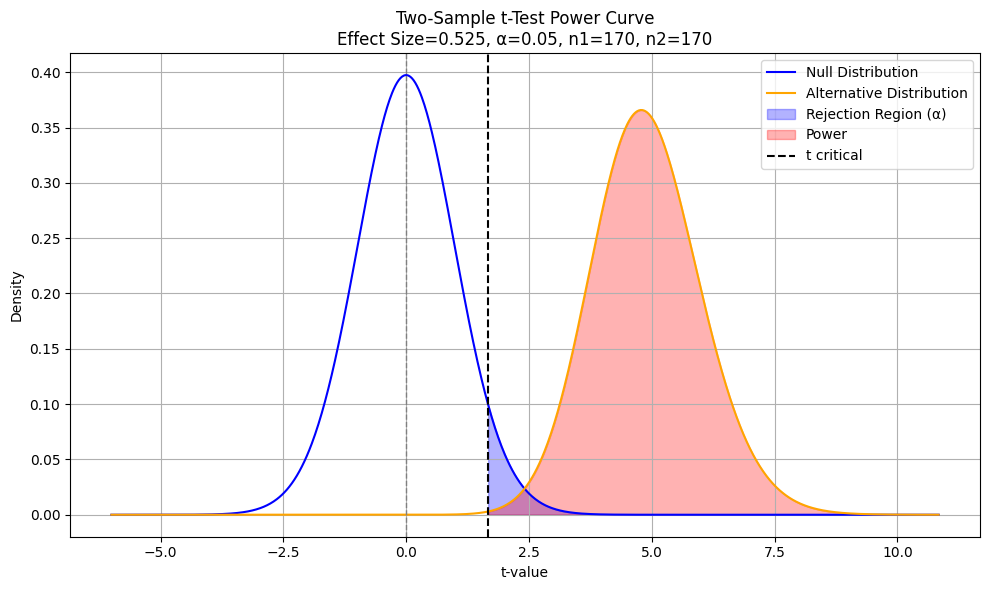

In [314]:
def plot_power_curve_with_distributions(effect_size, n1, n2, df, alpha=0.05, alternative='two-sided', normal_approx_threshold=350):
    ncp = effect_size * np.sqrt((n1 * n2) / (n1 + n2))

    use_normal_approx = df > normal_approx_threshold

    # x-axis range
    x = np.linspace(-6, 6 + ncp, 1000)

    # Null distribution (central t)
    null_pdf = stats.t.pdf(x, df) if not use_normal_approx else stats.norm.pdf(x, 0, 1)

    # Alternative distribution
    alt_pdf = stats.nct.pdf(x, df, ncp) if not use_normal_approx else stats.norm.pdf(x, ncp, 1)

    # Critical values
    if alternative == 'two-sided':
        t_crit_low = stats.t.ppf(alpha / 2, df) if not use_normal_approx else stats.norm.ppf(alpha / 2)
        t_crit_high = stats.t.ppf(1 - alpha / 2, df) if not use_normal_approx else stats.norm.ppf(1 - alpha / 2)
    else:
        t_crit = stats.t.ppf(1 - alpha, df) if not use_normal_approx else stats.norm.ppf(1 - alpha)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x, null_pdf, label='Null Distribution', color='blue')
    plt.plot(x, alt_pdf, label='Alternative Distribution', color='orange')

    # Shading rejection regions and power regions
    if alternative == 'two-sided':
        plt.fill_between(x, 0, null_pdf, where=(x <= t_crit_low) | (x >= t_crit_high), color='blue', alpha=0.3, label='Rejection Region (α/2)')
        plt.fill_between(x, 0, alt_pdf, where=(x <= t_crit_low) | (x >= t_crit_high), color='red', alpha=0.3, label='Power')
        plt.axvline(t_crit_low, color='black', linestyle='--', label='-t critical')
        plt.axvline(t_crit_high, color='black', linestyle='--', label='t critical')
    elif alternative == 'larger':
        plt.fill_between(x, 0, null_pdf, where=(x >= t_crit), color='blue', alpha=0.3, label='Rejection Region (α)')
        plt.fill_between(x, 0, alt_pdf, where=(x >= t_crit), color='red', alpha=0.3, label='Power')
        plt.axvline(t_crit, color='black', linestyle='--', label='t critical')
    elif alternative == 'smaller':
        plt.fill_between(x, 0, null_pdf, where=(x <= -t_crit), color='blue', alpha=0.3, label='Rejection Region (α)')
        plt.fill_between(x, 0, alt_pdf, where=(x <= -t_crit), color='red', alpha=0.3, label='Power')
        plt.axvline(-t_crit, color='black', linestyle='--', label='t critical')

    plt.axvline(0, color='gray', linestyle='--', linewidth=1)
    plt.title(f'Two-Sample t-Test Power Curve\nEffect Size={effect_size}, α={alpha}, n1={n1}, n2={n2}')
    plt.xlabel('t-value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_power_curve_with_distributions(effect_size=0.525, n1=170, n2=170, df=64, alpha=0.05, alternative='larger')


### Sample Size Calc

In [ ]:
def sample_size_two_sample_ttest_equal_variance(effect_size, power_target=0.8, alpha=0.05,
                                                alternative='two-sided', allocation_ratio=2.0):
    
    z_alpha = norm.ppf(1 - alpha / 2) if alternative == 'two-sided' else norm.ppf(1 - alpha)
    z_beta = norm.ppf(power_target)

    # n1 is the size of the smaller (or reference) group
    n1 = ((z_alpha + z_beta) ** 2 * (1 + allocation_ratio)) / (effect_size ** 2)
    n2 = n1 / allocation_ratio

    return np.ceil(n1), np.ceil(n2)

# Example usage:
n_required = sample_size_two_sample_ttest_equal_variance(effect_size=0.5, power_target=0.8, alpha=0.05, alternative="two-sided", allocation_ratio=1.0)
print(f"Required sample size per group: {n_required}")

Required sample size per group: (np.float64(50.0), np.float64(50.0))


In [378]:
def sample_size_two_sample_ttest_unequal_variance(mu1, mu2, s1, s2, power_target=0.8, alpha=0.05,
                                                  alternative='two-sided', allocation_ratio=2.0):
    
    if mu1 == mu2:
        raise ValueError("Means are equal. Effect size is zero, so required sample size is infinite.")

    z_alpha = norm.ppf(1 - alpha / 2) if alternative == 'two-sided' else norm.ppf(1 - alpha)
    z_beta = norm.ppf(power_target)

    # n1 is the size of the smaller (or reference) group
    n1 = ((z_alpha + z_beta) ** 2 * (s1 ** 2 + s2 ** 2 * allocation_ratio)) / ((mu1 - mu2) ** 2)
    n2 = n1 / allocation_ratio

    return np.ceil(n1), np.ceil(n2)

# Example usage:
n_required = sample_size_two_sample_ttest_unequal_variance(mu1=0, mu2=0, s1=1, s2=1, power_target=0.8, alpha=0.05, alternative="two-sided", allocation_ratio=1.0)
print(f"Required sample size per group: {n_required}")

ValueError: Means are equal. Effect size is zero, so required sample size is infinite.

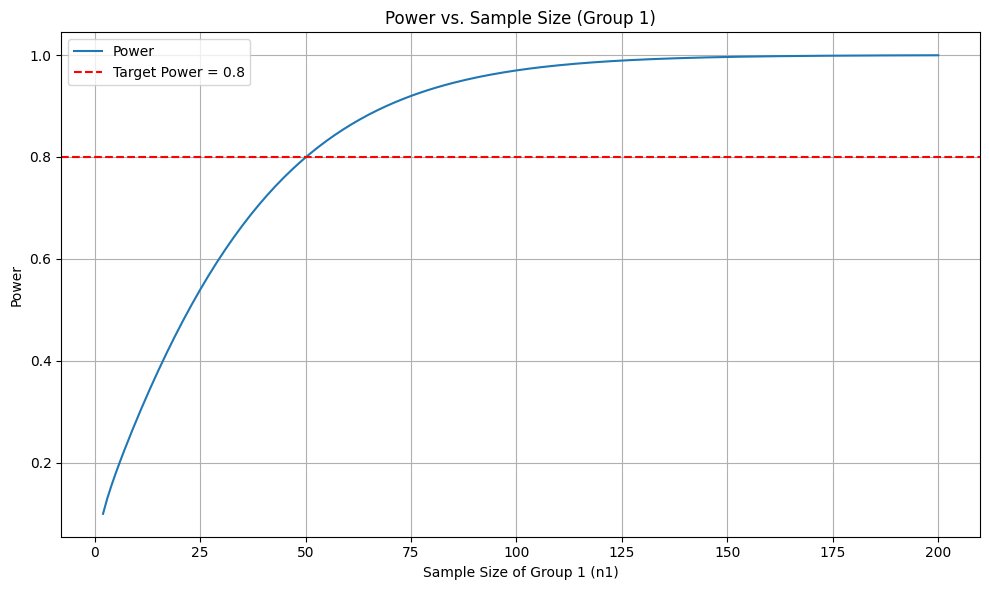

In [369]:
def plot_power_curve_equal_variance(effect_size, alpha=0.05, power_target=0.8, alternative='two-sided', allocation_ratio=1.0, max_n1=200):
    n1_values = np.arange(2, max_n1 + 1)
    power_values = []

    for n1 in n1_values:
        n2 = n1 / allocation_ratio
        power, df = power_two_sample_ttest_equal_variance(effect_size=effect_size, n1=n1, n2=n2, alpha=alpha, alternative=alternative)
        power_values.append(power)

    plt.figure(figsize=(10, 6))
    plt.plot(n1_values, power_values, label=f'Power', )
    plt.axhline(y=power_target, color='red', linestyle='--', label=f'Target Power = {power_target}')
    plt.xlabel('Sample Size of Group 1 (n1)')
    plt.ylabel('Power')
    plt.title('Power vs. Sample Size (Group 1)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_power_curve_equal_variance(effect_size=0.5, alpha=0.05, power_target=.8, alternative='larger', allocation_ratio=1.0, max_n1=200)

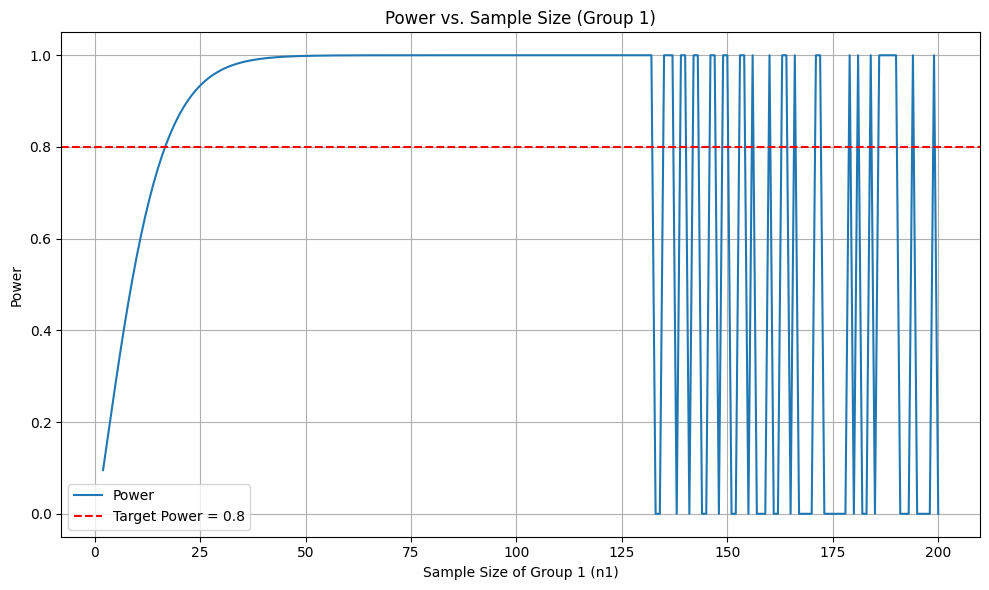

In [379]:
def plot_power_curve_unequal_variance(mu1, mu2, s1, s2, alpha=0.05, power_target=0.8, alternative='two-sided', allocation_ratio=1.0, max_n1=200):
    n1_values = np.arange(2, max_n1 + 1)
    power_values = []

    for n1 in n1_values:
        n2 = n1 / allocation_ratio
        power, effect_size, df = power_two_sample_ttest_unequal_variance(mu1=mu1, mu2=mu2, s1=s1, s2=s2, n1=n1, n2=n2, alpha=alpha, alternative=alternative)
        power_values.append(power)

    plt.figure(figsize=(10, 6))
    plt.plot(n1_values, power_values, label=f'Power', )
    plt.axhline(y=power_target, color='red', linestyle='--', label=f'Target Power = {power_target}')
    plt.xlabel('Sample Size of Group 1 (n1)')
    plt.ylabel('Power')
    plt.title('Power vs. Sample Size (Group 1)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_power_curve_unequal_variance(mu1=1, mu2=0, s1=1, s2=1, alpha=0.05, power_target=.8, alternative='two-sided', allocation_ratio=1.0, max_n1=200)

### Effect Size

In [389]:
print("SciPy version:", matplotlib.__version__)

SciPy version: 3.10.3


In [ ]:
def effect_size_two_sample_ttest(n1, n2, power_target=0.8, alpha=0.05, alternative='two-sided'):
    df = n1 + n2 - 2

    if alternative == 'two-sided':
        t_alpha = t.ppf(1 - alpha / 2, df)
        t_beta = t.ppf(power_target, df)
    elif alternative == 'larger':
        t_alpha = t.ppf(1 - alpha, df)
        t_beta = t.ppf(power_target, df)
    else:
        t_alpha = -1 * t.ppf(1 - alpha, df)
        t_beta = -1 * t.ppf(power_target, df)

    se_term = np.sqrt(1/n1 + 1/n2)
    d_min = (t_alpha + t_beta) * se_term
    
    return d_min

effect_size_two_sample_ttest(50, 50, alternative='smaller')

-1.6605512170440568 -0.8453043896190998


np.float64(-0.5011711213326313)